In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit, time
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from PIL import Image
import skimage

from skimage import measure

Using TensorFlow backend.


In [ ]:
#path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
path = r"C:\\Users\\naren\\Documents\\LER\\"

#model = load_model(path + 'models/' + 'Linenet_round_L2_epoch_4.h5')

model = load_model(path + 'LER_machine_learning\\models\\' + 'Linenet_round_L2_6layer_epoch_4.h5')
model.summary()

In [20]:
np.random.seed(21)
sigma = 1.0
alpha = 0.5
Xi = 30
width = 20
space = 40
noise = 4
shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 

original_file = path + 'original_images2/oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
noisy_file = path + 'noisy_images2/nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'
linescan_file = path + 'linescans/linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'

im = np.array(Image.open(original_file))
im = im/256

imnoisy = np.array(Image.open(noisy_file))
imnoisy = (imnoisy)/256
imnoisy = imnoisy + np.random.normal(0, 0.05 * (256/255), imnoisy.shape)

imnoisy = imnoisy.reshape(1,1024,64,1)

start = time.time()
predict = model.predict(imnoisy)
prediction_time = time.time() - start
print(prediction_time)
imnoisy = imnoisy.reshape(1024,64)
predict = predict.reshape(1024,64,2)

3.0206551551818848


In [21]:
linescan = []
with open(linescan_file,'r') as f:
    for i,line in enumerate(f):
        if i < 3000:
            a, b = line.split(',')
            linescan.append(float(b))
        else:
            break
linescan = linescan[:2048]
leftline = np.array(linescan[:1024])
rightline = linescan[1024:]
rightline.reverse()
rightline = np.array(rightline)
leftline = leftline + shift
rightline = rightline + shift

edgeimage = np.zeros((1024,64))
for i in range(1024):
    if leftline[i] < 0:
        leftline[i] = 0
    if rightline[i] > 63:
        rightline[i] = 63
    edgeimage[i, leftline[i].round().astype(int)] = 1
    edgeimage[i, rightline[i].round().astype(int)] = 1

PSNR noisy image =  12.63584809014787
PSNR predicted image =  27.09453395847094


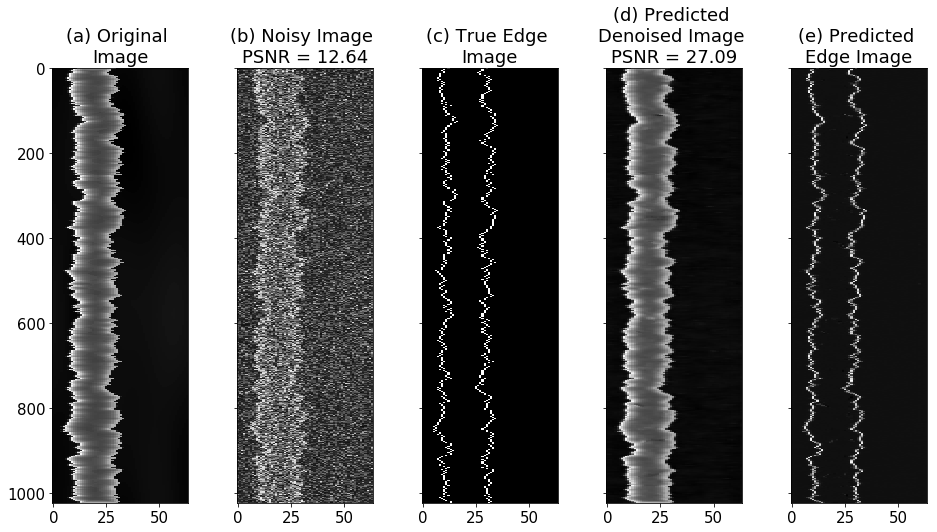

In [22]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16, 8), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

psnr_noisy = measure.compare_psnr(im,imnoisy.astype(float))
psnr_predict = measure.compare_psnr(im,predict[:,:,0].astype(float))
print('PSNR noisy image = ', psnr_noisy)
print('PSNR predicted image = ', psnr_predict)

ax[0].imshow(im,cmap = 'gray',aspect= 0.2)
ax[0].set_title('(a) Original \nImage', fontsize=18)
ax[0].tick_params(labelsize=15)

ax[1].imshow(imnoisy,cmap = 'gray',aspect= 0.2)
ax[1].set_title('(b) Noisy Image \nPSNR = {0:.4g}'.format(psnr_noisy), fontsize=18)
#ax[1].set_title('(b) Noisy Image', fontsize=16)
ax[1].tick_params(labelsize=15)

ax[2].imshow(edgeimage,cmap = 'gray',aspect= 0.2)
ax[2].set_title('(c) True Edge \nImage'.format(psnr_noisy), fontsize=18)
ax[2].tick_params(labelsize=15)

ax[3].imshow(predict[:,:,0], cmap = 'gray',aspect= 0.2)
ax[3].set_title('(d) Predicted \nDenoised Image \nPSNR = {0:.4g}'.format(psnr_predict), fontsize=18)
ax[3].tick_params(labelsize=15)

ax[4].imshow(predict[:,:,1], cmap = 'gray',aspect= 0.2)
ax[4].set_title('(e) Predicted \nEdge Image', fontsize=18)
ax[4].tick_params(labelsize=15)

plt.show()


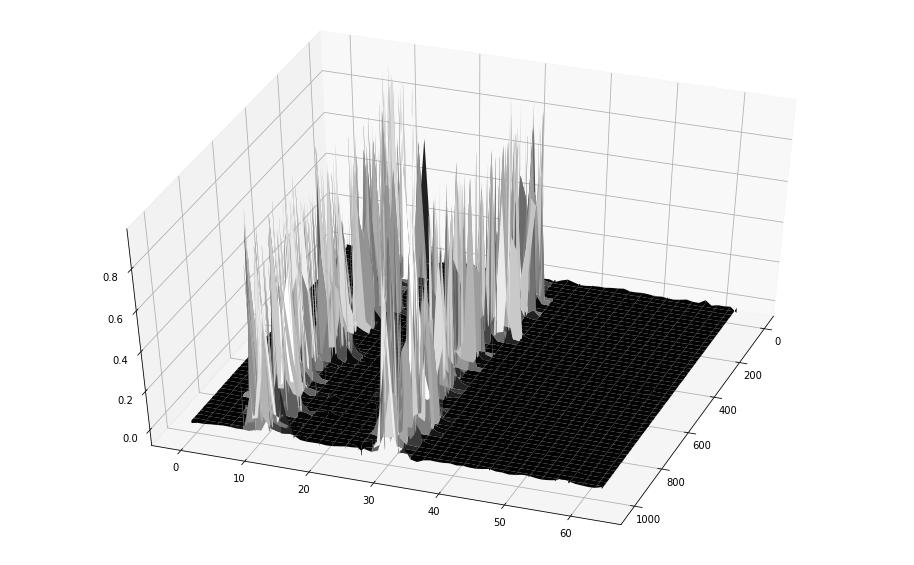

In [23]:
# code for 3d plot

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111,projection='3d')
ax.view_init(elev=45., azim=20)


x, y = np.mgrid[0:1024, 0:64]
surf = Axes3D.plot_surface(ax, x, y, predict[:,:,1], cmap=cm.gray)

#ax.grid(False)
# Hide axes ticks
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#plt.axis('off')

# make the panes transparent
#ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
plt.show()

(array([11, 32], dtype=int64), {'peak_heights': array([0.76579744, 0.54072767])})


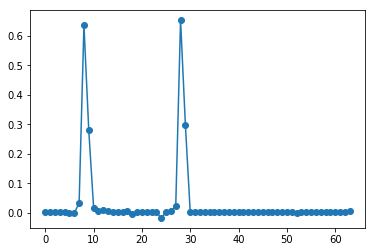

In [24]:
# code for fining peaks in a row.

from scipy.signal import find_peaks    # To get maxima

print(find_peaks(predict[100,:,1], height = 0.1, distance = 5))   # example peak detection
plt.plot(predict[710,:,1], '-o')           # plot one row of edge image
plt.show()

leftline_pred = np.zeros(1024)
rightline_pred = np.zeros(1024)


for i in range(1024):
    peaks, _ = find_peaks(predict[i,:,1], height = 0.1, distance = 5)    # height 0.1 and distance 5
    leftline_pred[i] = peaks[0]
    rightline_pred[i] = peaks[1]
    

292.0
481.0
Mean absolute position error = 0.37744140625
PSNR noisy image =  12.63584809014787
PSNR predicted image =  27.09453395847094
Original leftline sigma = 0.9269954911238591, rightline sigma = 0.9958251591005113
Predicted leftline sigma = 0.9025545740930621, rightline sigma = 1.1408614867149767
Original LWR = 1.280998391358127 
Predicted LWR = 1.3808551448341766 


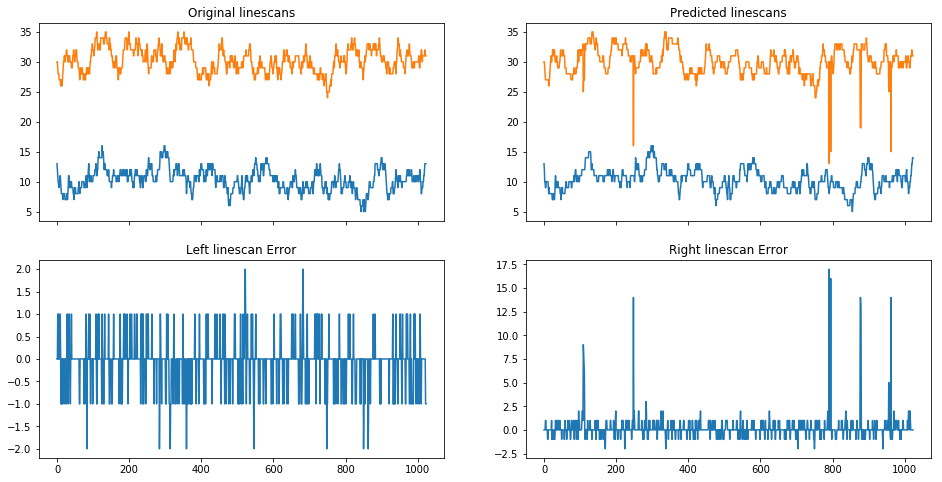

In [25]:
linescan_file = path + 'linescans/linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'
linescan = []
with open(linescan_file,'r') as f:
    for i, line in enumerate(f):
        if i < 3000:
            a, b = line.split(',')
            linescan.append(float(b))


linescan = linescan[:2048]

leftline = np.array(linescan[:1024]) 
rightline = linescan[1024:]
rightline.reverse()
rightline = np.array(rightline)

leftline = leftline + shift
rightline = rightline + shift

left_error = np.abs(leftline.round() - leftline_pred).sum()
right_error = np.abs(rightline.round() - rightline_pred).sum()
print(left_error)
print(right_error)
print('Mean absolute position error = {}'.format((left_error + right_error)/2048))

print('PSNR noisy image = ', psnr_noisy)
print('PSNR predicted image = ', psnr_predict)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), sharex=True,
                       sharey=False, subplot_kw={'adjustable': 'box-forced'})

print('Original leftline sigma = {}, rightline sigma = {}'.format(leftline.round().std()/2, \
                                                                  rightline.round().std()/2))

print('Predicted leftline sigma = {}, rightline sigma = {}'.format(leftline_pred.std()/2, \
                                                                  rightline_pred.std()/2))

Original_LWR = (rightline.round() - leftline.round()).std()/2
Predicted_LWR = ((rightline_pred - leftline_pred).std())/2

print('Original LWR = {} '.format(Original_LWR))
print('Predicted LWR = {} '.format(Predicted_LWR))


ax[0,0].plot(leftline.round())
ax[0,0].plot(rightline.round())
ax[0,0].set_title('Original linescans')

ax[0,1].plot(leftline_pred)
ax[0,1].plot(rightline_pred)
ax[0,1].set_title('Predicted linescans')

ax[1,0].plot(leftline.round() - leftline_pred)
ax[1,0].set_title('Left linescan Error')

ax[1,1].plot(rightline.round() - rightline_pred)
ax[1,1].set_title('Right linescan Error')
plt.show()

Left Bias:  259.13343492191456
Right Bias:  5357.010402868852
Left distance:  27.353907006752333
Right distance:  94.44871670693858


c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\spectrum-0.7.3-py3.5-win-amd64.egg\spectrum\mtm.py:529: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\spectrum-0.7.3-py3.5-win-amd64.egg\spectrum\mtm.py:530: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))
c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

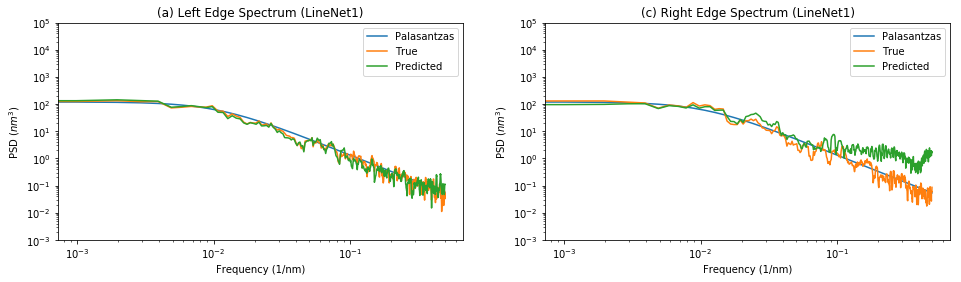

In [26]:
from spectrum import pmtm

# Spectrum analysis code by Sai
NFFT_VAL = 1024
range_psd = int(NFFT_VAL/2)

#leftmean = leftline.mean()
#rightmean = rightline.mean()
leftmean = 30 + shift                     # Change the mean to zero
rightmean = 30 + shift + width            # Change the mean to zero

leftline_spec = leftline - leftmean
rightline_spec = rightline - rightmean

#leftpred_spec = (linepredict*64).round()[:,0] - (linepredict*64).round()[:,0].mean()
#rightpred_spec = (linepredict*64).round()[:,1] - (linepredict*64).round()[:,1].mean()

leftpred_spec = leftline_pred - leftmean
rightpred_spec = rightline_pred - rightmean

left_multitape_spectrum = pmtm(leftline_spec, NFFT = NFFT_VAL, NW = 4, k=6, method = 'adapt', show = False)
left_Sk = abs(left_multitape_spectrum[0])**2
left_Sk = np.mean(left_Sk * np.transpose(left_multitape_spectrum[1]), axis = 0)
left_Sk = np.fft.fftshift(left_Sk)

right_multitape_spectrum = pmtm(rightline_spec, NFFT = NFFT_VAL, NW = 4, k=6, method = 'adapt', show = False)
right_Sk = abs(right_multitape_spectrum[0])**2
right_Sk = np.mean(right_Sk * np.transpose(right_multitape_spectrum[1]), axis = 0)
right_Sk = np.fft.fftshift(right_Sk)

left_multitape_spectrum_predict = pmtm(leftpred_spec, NFFT = NFFT_VAL, NW = 4, k=6, method = 'adapt', show = False)
left_Sk_predict = abs(left_multitape_spectrum_predict[0])**2
left_Sk_predict = np.mean(left_Sk_predict * np.transpose(left_multitape_spectrum_predict[1]), axis = 0)
left_Sk_predict = np.fft.fftshift(left_Sk_predict)

right_multitape_spectrum_predict = pmtm(rightpred_spec, NFFT = NFFT_VAL, NW = 4, k=6, method = 'adapt', show = False)
right_Sk_predict = abs(right_multitape_spectrum_predict[0])**2
right_Sk_predict = np.mean(right_Sk_predict * np.transpose(right_multitape_spectrum_predict[1]), axis = 0)
right_Sk_predict = np.fft.fftshift(right_Sk_predict)


left_bias = np.sum(np.abs((left_Sk_predict[512:] - left_Sk[512:])/left_Sk[512:]))
right_bias = np.sum(np.abs((right_Sk_predict[512:] - right_Sk[512:])/right_Sk[512:]))

left_distance = np.linalg.norm(left_Sk_predict[512:] - left_Sk[512:])
right_distance = np.linalg.norm(right_Sk_predict[512:] - right_Sk[512:])

print('Left Bias: ', left_bias)
print('Right Bias: ', right_bias)

print('Left distance: ', left_distance)
print('Right distance: ', right_distance)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True,
                       sharey=False, subplot_kw={'adjustable': 'box-forced'})

#x_axis = np.arange(512)/1024

N, L = 1024, 2048*1e-09
freq = np.zeros(1024)
for i in range(N):
    freq[i] = i - (N/2)
freq = 2*np.pi*freq/L

num = (np.sqrt(np.pi))*(math.gamma(alpha + 0.5)/math.gamma(alpha))*(2*(Xi*1e-09)*(sigma*1e-09)**2)
denom = (1 +(freq*Xi*1e-09)**2)**(alpha + 0.5)

PSD = num/denom


x_axis = freq[512:]*1e-09/(np.pi)

ax[0].plot(x_axis,1e27 * PSD[512:] * (L*1e09)/N, label = 'Palasantzas')
ax[0].plot(x_axis,left_Sk[512:], label = 'True')
ax[0].plot(x_axis,left_Sk_predict[512:], label = 'Predicted')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel('Frequency (1/nm)')
ax[0].set_ylabel('PSD ($nm^3$)')
ax[0].set_title('(a) Left Edge Spectrum (LineNet1)')
ax[0].legend()
ax[0].set_ylim(0.001, 100000)
#ax[0].axvline(x=1/(2*np.pi*Xi))

ax[1].plot(x_axis,1e27 * PSD[512:] * (L*1e09)/N, label = 'Palasantzas')
ax[1].plot(x_axis,right_Sk[512:], label = 'True')
ax[1].plot(x_axis,right_Sk_predict[512:], label = 'Predicted')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('Frequency (1/nm)')
ax[1].set_ylabel('PSD ($nm^3$)')
ax[1].set_title('(c) Right Edge Spectrum (LineNet1)')
ax[1].legend()
ax[1].set_ylim(0.001, 100000)
#ax[1].axvline(x=1/(2*np.pi*Xi))

plt.show()

c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


5.131715053399989e-10
1.9531250000000002


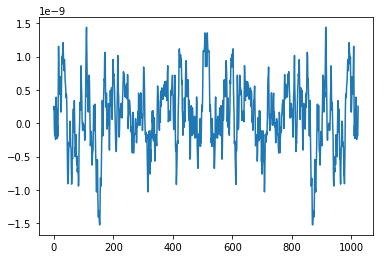

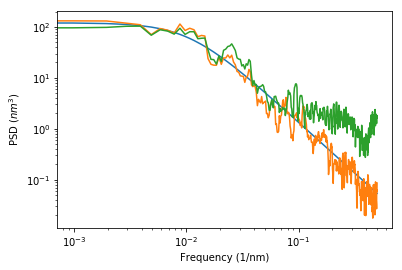

In [27]:


FFT_edge = np.zeros(N);
j = 0
while j < (N//2):
        if(j == 0):
            FFT_edge[j + N//2] = np.sqrt(PSD[j + N//2])*np.random.normal()
        else:
            FFT_edge[j + N//2] = np.sqrt(PSD[j + N//2])*(np.random.normal() + 1j*np.random.normal())/np.sqrt(2)
        j += 1

j = 1            
while j < N//2 - 1:
    FFT_edge[j] = np.conj(FFT_edge[N - j])   #Make PSD symmetric because edge is real  
    j += 1 

FFT_edge[0] = np.sqrt(PSD[0])*np.random.normal()

e = np.fft.ifft(np.fft.fftshift((N/np.sqrt(L))*FFT_edge))
print(e.std())
print((L/N**2) * 1e12)
plt.plot(e)
plt.show()

e_FFT = np.abs(np.fft.fftshift(np.fft.fft(e)))


#plot2, = plt.plot(freq[512:]*1e-09/(np.pi), 1e27 * np.abs(FFT_edge)[512:]**2)
plot1, = plt.plot(freq[512:]*1e-09/(np.pi), 1e27 * PSD[512:] * (L*1e09)/N)
#plt.plot(freq[512:]*1e-09/(np.pi), L/(N**2) * 1e27 * e_FFT[512:]**2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Frequency (1/nm)')
plt.ylabel('PSD ($nm^3$)')
plt.plot(freq[512:]*1e-09/(np.pi), right_Sk[512:])
plt.plot(x_axis, right_Sk_predict[512:])

#plt.legend([plot1,plot2],["Palasantzas PSD", "Random PSD"])

plt.show()